# Comparing color-color tracks of the stellar templates

The goal of this notebook is to compare the stellar loci (in various color-color spaces) of the (theoretical) templates to the observed loci.

In [1]:
import os

import numpy as np
import fitsio
import matplotlib.pyplot as plt

from speclite import filters
from astropy import constants
import astropy.units as u
from desisim.io import read_basis_templates

import seaborn as sns

%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
sns.set(style='white', font_scale=1.8, font='sans-serif', palette='Set2')
setcolors = sns.color_palette()

### Read a random sweep, select stars, and correct the observed fluxes for reddening

In [3]:
def read_and_dered():
    bright, faint = 18, 19.5
    
    sweepfile = 'sweep-240p000-250p005.fits'
    print('Reading {}...'.format(sweepfile))
    cat = fitsio.read(sweepfile, ext=1, upper=True)
    
    these = np.where( (np.char.strip(cat['TYPE'].astype(str)) == 'PSF') * 
                     (cat['DECAM_FLUX'][..., 2] > 1e9 * 10**(-0.4*faint)) *
                     (cat['DECAM_FLUX'][..., 2] < 1e9 * 10**(-0.4*bright))
                    )[0]
    cat = cat[these]
    print('...and selected {} stars with {} < r < {}.'.format(len(cat), bright, faint))

    for prefix in ('DECAM', 'WISE'):
        cat['{}_FLUX'.format(prefix)] = ( cat['{}_FLUX'.format(prefix)] / 
                                         cat['{}_MW_TRANSMISSION'.format(prefix)] )
        cat['{}_FLUX_IVAR'.format(prefix)] = ( cat['{}_FLUX_IVAR'.format(prefix)] * 
                                               cat['{}_MW_TRANSMISSION'.format(prefix)]**2 )
    
    return cat

In [4]:
cat = read_and_dered()

Reading sweep-240p000-250p005.fits...
...and selected 37830 stars with 18 < r < 19.5.


## Load the filter curves, the stellar templates, and get synthetic colors.

In [5]:
def obsflux2colors(cat):
    """Convert observed DECam/WISE fluxes to magnitudes and colors."""
    cc = dict()
    with warnings.catch_warnings(): # ignore missing fluxes (e.g., for QSOs)
        warnings.simplefilter('ignore')
        for ii, band in zip((1, 2, 4), ('g', 'r', 'z')):
            cc[band] = 22.5 - 2.5 * np.log10(cat['DECAM_FLUX'][..., ii].data)
        for ii, band in zip((0, 1), ('W1', 'W2')):
            cc[band] = 22.5 - 2.5 * np.log10(cat['WISE_FLUX'][..., ii].data)
    cc['gr'] = cc['g'] - cc['r']
    cc['gz'] = cc['g'] - cc['z']
    cc['rz'] = cc['r'] - cc['z']    
    cc['rW1'] = cc['r'] - cc['W1']
    cc['zW1'] = cc['z'] - cc['W1']
    cc['W1W2'] = cc['W1'] - cc['W2']
    return cc

In [6]:
def synthflux2colors(synthflux):
    """Convert the synthesized DECam/WISE fluxes to colors."""
    cc = dict(
        r = 22.5 - 2.5 * np.log10(synthflux[1, :]), 
        gr = -2.5 * np.log10(synthflux[0, :] / synthflux[1, :]),
        rz = -2.5 * np.log10(synthflux[1, :] / synthflux[2, :]),
        gz = -2.5 * np.log10(synthflux[0, :] / synthflux[2, :]),
        rW1 = -2.5 * np.log10(synthflux[1, :] / synthflux[3, :]),
        zW1 = -2.5 * np.log10(synthflux[2, :] / synthflux[3, :]),
    )
    return cc

In [7]:
def star_synthflux():
    """Read the DESI stellar templates and synthesize photometry."""
    flux, wave, meta = read_basis_templates(objtype='STAR')
    nt = len(meta)
    print('Read {} DESI templates.'.format(nt))
    
    phot = filt.get_ab_maggies(flux, wave, mask_invalid=False)
    synthflux = np.vstack( [phot[ff].data for ff in filts] )
    
    return synthflux

In [8]:
def pickles_synthflux():
    """Read the Pickles+98 stellar templates and synthesize photometry."""
    picklefile = os.path.join(os.getenv('CATALOGS_DIR'), '98pickles', '98pickles.fits')
    data = fitsio.read(picklefile, ext=1)
    print('Read {} Pickles templates.'.format(len(data)))
    
    wave = data['WAVE'][0, :]
    flux = data['FLUX']
    
    padflux, padwave = filt.pad_spectrum(flux, wave, method='edge')

    phot = filt.get_ab_maggies(padflux, padwave, mask_invalid=False)
    synthflux = np.vstack( [phot[ff].data for ff in filts] )
    
    return synthflux

In [9]:
filts = ('decam2014-g', 'decam2014-r', 'decam2014-z', 'wise2010-W1', 'wise2010-W2')
filt = filters.load_filters(*filts)

In [10]:
starcol = synthflux2colors(star_synthflux())

INFO:io.py:625:read_basis_templates: Reading /Users/ioannis/research/projects/desi/spectro/templates/basis_templates/v2.3/star_templates_v2.1.fits
Read 931 DESI templates.


In [11]:
picklecol = synthflux2colors(pickles_synthflux())

Read 131 Pickles templates.


In [12]:
obscol = obsflux2colors(cat)

## Generate color-color plots.

In [13]:
grrange = (-0.6, 2.2)
gzrange = (0.0, 4.0)
rzrange = (-0.6, 2.8)
zW1range = (-2.5, 0.0)

In [14]:
def grz(pngfile=None):
    fig, ax = plt.subplots(figsize=(10, 6))
    if False:
        hb = ax.scatter(obscol['rz'], obscol['gr'], c=obscol['r'], s=1, 
                        edgecolor='none')
    else:
        hb = ax.hexbin(obscol['rz'], obscol['gr'], mincnt=5,
                      bins='log', gridsize=150)
    ax.scatter(picklecol['rz'], picklecol['gr'], marker='s', 
               s=40, linewidth=1, alpha=0.5, label='Pickles+98', c='r')
    ax.scatter(starcol['rz'], starcol['gr'], marker='o', 
               s=10, linewidth=1, alpha=0.8, label='STAR Templates', c='b')
    ax.set_xlabel('r - z')
    ax.set_ylabel('g - r')
    ax.set_xlim(rzrange)
    ax.set_ylim(grrange)
    lgnd = ax.legend(loc='upper left', frameon=False, fontsize=18)
    lgnd.legendHandles[0]._sizes = [100]
    lgnd.legendHandles[1]._sizes = [100]
    cb = fig.colorbar(hb, ax=ax)
    cb.set_label(r'log$_{10}$ (Number of 18<r<19.5 Stars per Bin)')
    if pngfile:
        fig.savefig(pngfile)

In [15]:
def gzW1(pngfile=None):
    fig, ax = plt.subplots(figsize=(10, 6))
    hb = ax.hexbin(obscol['zW1'], obscol['gz'], mincnt=10,
                  bins='log', gridsize=150)
    ax.scatter(starcol['zW1'], starcol['gz'], marker='o', 
               s=10, alpha=0.5, label='STAR Templates', c='b')
    ax.set_xlabel('z - W1')
    ax.set_ylabel('g - z')
    ax.set_ylim(gzrange)
    ax.set_xlim(zW1range)
    lgnd = ax.legend(loc='upper left', frameon=False, fontsize=18)
    lgnd.legendHandles[0]._sizes = [100]
    cb = fig.colorbar(hb, ax=ax)
    cb.set_label(r'log$_{10}$ (Number of 18<r<19.5 Stars per Bin)')
    if pngfile:
        fig.savefig(pngfile)

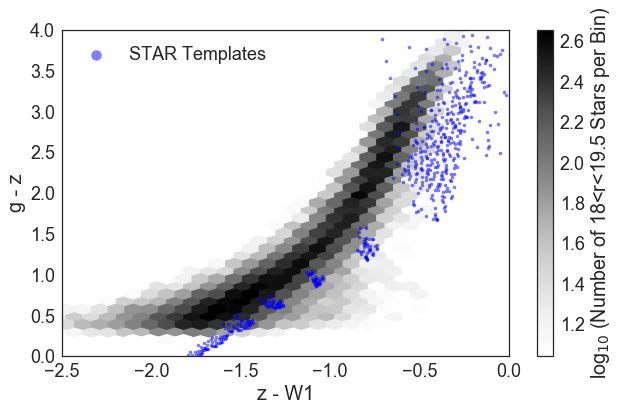

In [16]:
gzW1()

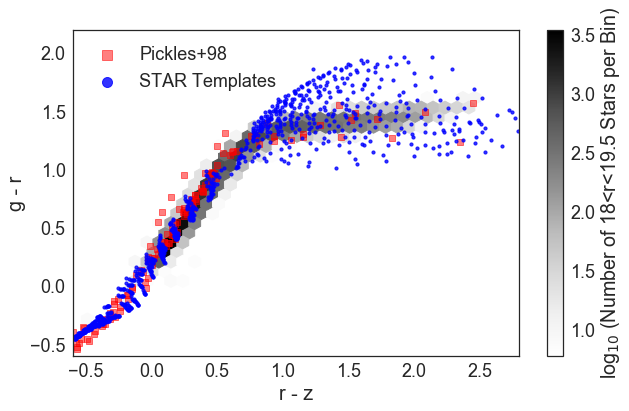

In [17]:
grz()